# M31 2015 Luminous Red Nova, timescales

### Tassos Fragkos & Jeff J. Andrews

In this notebook we are calculating relevant timescales for different donor and accretor stars at various times throughout the donor's lifetime. 

In [1]:
# modules
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import matplotlib.patches as mpatches

%matplotlib inline

In [2]:
# constants in cgs
Gconst = 6.674e-8
Msun = 1.989e33
Rsun = 6.957e10
secday = 3600.0*24.0
secyear = secday * 365.25

### Load MESA data

In [3]:
data_dir = '/data/disk1/fragkos/mesa_projects/CE/make_starting_models/'

# 15 Msun giant
file_dir = data_dir + 'CE_paperI_StartingModel_15M_755R.data'
M15_755R = np.genfromtxt(file_dir, skip_header=5, names=True)

# 30 Msun giant
file_dir = data_dir + 'CE_paperI_StartingModel_30M_1400R.data'
M30_1400R = np.genfromtxt(file_dir, skip_header=5, names=True)


In [4]:
def set_interpolations(star):
    star_m_encl = interp1d(star['radius']*Rsun, star['mass']*Msun)
    star_log10_rho = interp1d(star['radius']*Rsun, star['logRho'])
    star_pressure_scale_height = interp1d(star['radius']*Rsun, star['pressure_scale_height']*Rsun)
    star_csound = interp1d(star['radius']*Rsun, star['csound'])
    star_t_thermal_to_surf = interp1d(star['radius']*Rsun, 10**star['log_thermal_time_to_surface'])
    dM_dr = star["dm"]/star["dr"]
    star_dM_dr = interp1d(star['radius']*Rsun, dM_dr)

    return star_m_encl, star_log10_rho, star_pressure_scale_height, star_csound, star_t_thermal_to_surf, star_dM_dr

In [5]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12



### Keplerian velocity function

In [6]:
def get_keplerian_velocity(M_enclosed, M_companion, a_separation):
    """ Provides the keplerian velocity (circular orbit)
    
    Arguments
    ---------
    M_enclosed : float
        Enclosed mass of the companion, assumed to be a point (Msun)
    M_companion : float
        Companion mass (Msun)
    a_separation : float
        Orbital separation (Rsun)
        
    Returns
    -------
    v_orb : float
        circular orbital velocity (km/s)
    """
    
    v_squared = Gconst * (M_enclosed + M_companion) * Msun / (a_separation * Rsun)
    v_orb = np.sqrt(v_squared) / 1.0e5 # converted from cm/s to km/s
    
    return v_orb

### Gravitational potential

In [7]:
def get_E_grav(M_enclosed, M_companion, a_separation):
    """ Provides the gravitational potential energy
    
    Arguments
    ---------
    M_enclosed : float
        Enclosed mass of the companion, assumed to be a point (Msun)
    M_companion : float
        Companion mass (Msun)
    a_separation : float
        Orbital separation (Rsun)
        
    Returns
    -------
    E_grav : float
        gravitational potential energy (erg)
    """

    E_grav = -Gconst * (M_enclosed*Msun) * (M_companion*Msun) / (a_separation*Rsun)
    
    return E_grav

### Orbital period

In [8]:
def get_P_orb(M_enclosed, M_companion, a_separation):
    """ Provides the orbital period
    
    Arguments
    ---------
    M_enclosed : float
        Enclosed mass of the companion, assumed to be a point (Msun)
    M_companion : float
        Companion mass (Msun)
    a_separation : float
        Orbital separation (Rsun)
        
    Returns
    -------
    P_orb : float
        Orbital period (s)
    """

    vel = get_keplerian_velocity(M_enclosed, M_companion, a_separation) * 1.0e5 # velocity in cm/s
    circumference = 2.0 * np.pi * a_separation*Rsun
    
    P_orb = circumference / vel
    
    return P_orb

### Define the frictional drag force from MacLeod & Ramirez-Ruiz (2015)

In [9]:
def get_F_drag(mass_in, vel_in, rho, scale_height):
    """ Provides the drag force from an inspiraling object
    
    Arguments
    ---------
    mass_in : float
        Companion mass (Msun)
    vel_in : float
        Companion velocity - assumed to be the Keplerian orbital (km/s)
    rho : float
        Local density (g/cm^3)
    scale_height : float
        Local pressure scale height (cm)
        
    Returns
    -------
    F_drag : float
        Drag force on the inspiraling companion (erg/s)
    """
    
    # Convert units to cgs
    mass = mass_in * Msun # Msun to g
    vel = vel_in * 1.0e5 # km/s to cm/s
        
    # Accretion radius
    R_accretion = 2.0 * Gconst * mass / vel**2
    
    # ratio of accretion radius to scale height
    eta = R_accretion / scale_height

    # Hoyle-Littleton drag
    F_drag_HL = np.pi * R_accretion**2 * rho * vel**2
    
    # Factor to adjust Hoyle-Littleton drag to MacLeod & Ramirez-Ruiz (2015) simulations
    f_factor = 1.91791946 + -1.52814698*eta + 0.75992092*eta**2
        
    # Drag force
    F_drag = F_drag_HL * f_factor
    
    return F_drag

### Now, let's define derivatives for the inspiral over the static stellar profile

In [43]:
def get_dE_dr(E_in, r_in, M_companion, star_m_encl, star_dM_dr):
    """ Calculates the energy dissipation rate with respect to radius
    
    Arguments
    ---------
    E_in : float
        Total energy dissipated in star (erg)
    star_m_encl : interp1d object
        Enclosed mass interpolation object (Msun)
    star_dM_dr : interp1d object
        dM_dr interpolation object (g/cm)
    r_in : float
        The radius in question (cm)
    M_companion : float
        The companion mass to the star (Msun)
        
    Returns
    -------
    dE_dr : float
        The derivative of radius with respect to radius (erg/cm)    
    """
    
    # Calculate dE_dr
    m_encl = star_m_encl(r_in)
    dM_dr = star_dM_dr(r_in)
    dE_dr = -Gconst * dM_dr * (M_companion*Msun) / (2.0*r_in) + Gconst * (m_encl * (M_companion*Msun)) / (2.0*r_in**2)

    return dE_dr



    
def get_dE_dt(E_in, r_in, M_companion, star_m_encl, star_log10_rho, star_pressure_scale_height):
    """ Calculates the energy dissipation rate
    
    Arguments
    ---------
    E_in : float
        Total energy dissipated in star (erg)
    r_in : float
        The radius in question (cm)
    M_companion : float
        The companion mass to the star (Msun)
    star_m_encl : interp1d object
        Enclosed mass interpolation object (Msun)
    star_log10_rho : interp1d object
        log10 density interpolation object (g/cm^3)
    star_pressure_scale_height : interp1d object
        Pressure scale height interpolation object (cm)
        
    Returns
    -------
    dE_dt : float
        The derivative of radius with respect to time (erg/s)    
    """
    
    # Calculate dE_dt
    m_encl = star_m_encl(r_in)
    velocity = get_keplerian_velocity(m_encl/Msun, M_companion, r_in/Rsun)
    velocity0 = get_keplerian_velocity(star_m_encl(1400.*Rsun)/Msun, M_companion, 1400.)
    velocity = velocity -0.95*velocity0
    print(velocity)
    print(velocity0)

    rho = 10**star_log10_rho(r_in)
    scale_height = star_pressure_scale_height(r_in)
    dE_dt = -get_F_drag(M_companion, velocity, rho, scale_height) * (velocity*1.0e5)

    return dE_dt


    

def get_dr_dt(r_in, t_in, M_companion, star_m_encl, star_log10_rho, star_pressure_scale_height, star_dM_dr):
    """ Calculates the inspiral time of the star
    
    Arguments
    ---------
    r_in : float
        The radius in question (cm)
    t_in : float
        Latent variable for derivative
    M_companion : float
        The companion mass to the star (Msun)
    star_m_encl : interp1d object
        Enclosed mass interpolation object (Msun)
    star_log10_rho : interp1d object
        log10 density interpolation object (g/cm^3)
    star_pressure_scale_height : interp1d object
        Pressure scale height interpolation object (cm)
    star_dM_dr : interp1d object
        dM_dr interpolation object (g/cm)
        
    Returns
    -------
    dr_dt : float
        The derivative of radius with respect to time (cm/s)
    """
    
    # Calculate dE_dt
    m_encl = star_m_encl(r_in)
    
    velocity = get_keplerian_velocity(m_encl/Msun, M_companion, r_in/Rsun)
    velocity0 = get_keplerian_velocity(star_m_encl(1400.*Rsun)/Msun, M_companion, 1400.)
    velocity = velocity -0.95*velocity0
    
    rho = 10**star_log10_rho(r_in)
    scale_height = star_pressure_scale_height(r_in)
    dE_dt = -get_F_drag(M_companion, velocity, rho, scale_height) * (velocity*1.0e5)
    
    # Calculate dE_dr
    dM_dr = star_dM_dr(r_in)
    dE_dr = -Gconst * dM_dr * (M_companion*Msun) / (2.0*r_in) + Gconst * (m_encl * (M_companion*Msun)) / (2.0*r_in**2)
    
    # dr_dt
    dr_dt = dE_dt / dE_dr
        
    return dr_dt
    

In [44]:
def get_dE_dm(r_in, M_companion, star_m_encl, star_dM_dr):
    """ Calculates the energy deposited per mass
    
    Arguments
    ---------
    r_in : float
        The radius in question (cm)
    M_companion : float
        The companion mass to the star (Msun)
    star_m_encl : interp1d object
        Enclosed mass interpolation object (Msun)
    star_dM_dr : interp1d object
        dM_dr interpolation object (g/cm)
        
    Returns
    -------
    dE_dm : float
        The derivative of energy with respect to mass (eta)
    """
    m_encl = star_m_encl(r_in)
    dM_dr = star_dM_dr(r_in)

    dE_dr = -Gconst * dM_dr * (M_companion*Msun) / (2.0*r_in) + Gconst * (m_encl * (M_companion*Msun)) / (2.0*r_in**2)

    return dE_dr / dM_dr


In [45]:
star = M30_1400R
M_companion = 8.0
R_companion = 0.001#(M_companion)**0.8




star_m_encl, star_log10_rho, star_pressure_scale_height, star_csound, \
                             star_t_thermal_to_surf, star_dM_dr = set_interpolations(star)


# Determine the mass and radius at which the companion merges based on the Hill radius
r_hill = star['radius'] * (M_companion*Msun / (3.0 * star_m_encl(star['radius']*Rsun)))**(1./3.)

merger_idx = np.argmin(np.abs(R_companion - r_hill))
merger_mass = star['mass'][merger_idx]
merger_radius = star['radius'][merger_idx]

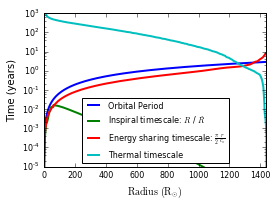

In [46]:
plt.figure(figsize=(4,3))

r_test = star["radius"]*Rsun
time = 0.0


def get_delta_t_therm(M_enclosed, M_companion, a_separation):

    vel = get_keplerian_velocity(M_enclosed, M_companion, a_separation) * 1.0e5 # velocity in cm/s
    R_accretion = 2.0 * Gconst * M_companion*Msun / vel**2

    t_thermal_low = star_t_thermal_to_surf(a_separation*Rsun)
    max_rad_array = star['radius'][0]*Rsun * np.ones(len(a_separation))
    t_thermal_high = star_t_thermal_to_surf(np.amin(np.vstack([a_separation*Rsun + R_accretion, max_rad_array]), axis=0))

    return t_thermal_high - t_thermal_low





dr_dt = get_dr_dt(r_test, time, M_companion, star_m_encl, star_log10_rho, star_pressure_scale_height, star_dM_dr)
P_orb = get_P_orb(star_m_encl(r_test)/Msun, M_companion, r_test/Rsun) / secyear
plt.plot(r_test/Rsun, P_orb, label='Orbital Period')
plt.plot(r_test/Rsun, np.abs(r_test / dr_dt / secyear), label=r'Inspiral timescale: $R$ / $\dot{R}$')



plt.plot(r_test/Rsun, np.pi/2. * r_test/star_csound(r_test) / secyear, label=r'Energy sharing timescale: $\frac{\pi}{2} \frac{r}{c_s}$')

# Energy radiation timescale
#plt.plot(star['radius'], star['energy']/star['luminosity'] / secday, color='c', label=r'Local thermal timescale: $E/L$')
plt.plot(star['radius'], 10**star['log_thermal_time_to_surface'] / secyear, color='c', label=r'Thermal timescale')



plt.xlabel(r'${\rm Radius}\ ({\rm R}_{\odot})$')
plt.ylabel('Time (years)')

plt.xlim(0.1, star['radius'][0])
plt.ylim(0.00001, 1000)
#plt.xscale('log')
plt.yscale('log')

plt.legend(loc=8,fontsize=8)

plt.tight_layout()


plt.savefig("timascales_30M_1400R.pdf")
plt.show()

In [42]:
import sys
sys.path.insert(0, '/data/disk1/fragkos/repos/CE_mesa/python_scripts')
import mesa as ms

run_path= "/data/disk1/fragkos/mesa_projects/CE/DVU_Mexico/8M_30M_1400R/"
#run_path= "/data/disk1/fragkos/mesa_projects/CE/DVU_Mexico/1.4M_15M_700R/"
run_names = [d for d in os.listdir(run_path) if os.path.isdir(os.path.join(run_path, d))]
run_names = ["step2_macleod_setE2_noMLT_noFL"]
data_path = run_path+run_names[0]+"/LOGS/"
a = ms.mesa(data_path=data_path, parallel=True, abundances=False, log_abundances = True, Yaxis='log_mass', Xaxis="log_inv_star_age",czones=False, Variable='v_div_vesc', orbit=True)



Process running in parallel on  48  cores
Process running in parallel on  48  cores


[  1.68003190e+03   1.68003004e+03   1.68002151e+03 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00]


/home/evol/fragkos/lib/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in divide
/home/evol/fragkos/lib/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/evol/fragkos/lib/anaconda2/lib/python2.7/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


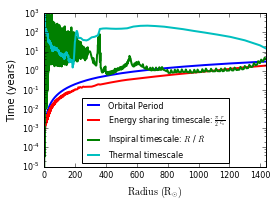

In [19]:

companion_position_m_at_profiles = np.interp(a.profile_age, a.history['star_age'],a.history["CE_companion_position_m"])
companion_position_r_at_profiles = np.interp(a.profile_age, a.history['star_age'],a.history["CE_companion_position_r"])
companion_position_r_at_profiles[np.where(companion_position_r_at_profiles<0.1)]=1

csound_at_companion = np.zeros(len(a.profile_age))
thermal_time_to_surface_at_companion = np.zeros(len(a.profile_age))

for i in range(len(a.profile_age)):
    thermal_interp = interp1d(10.**a.profiles[i]["logR"],10.**a.profiles[i]["log_thermal_time_to_surface"]/secyear)
    thermal_time_to_surface_at_companion[i] = thermal_interp(companion_position_r_at_profiles[i])
    csound_interp = interp1d(10**a.profiles[i]["logR"],a.profiles[i]["csound"])
    csound_at_companion[i] = csound_interp(companion_position_r_at_profiles[i])




plt.figure(figsize=(4,3))





P_orb = get_P_orb(companion_position_m_at_profiles, M_companion, companion_position_r_at_profiles) / secyear
plt.plot(companion_position_r_at_profiles, P_orb, label='Orbital Period',color="b")


d_CE_companion_position_r_dt = -np.gradient(a.history["CE_companion_position_r"])/(10.**a.history["log_dt"])

plt.plot(companion_position_r_at_profiles, np.pi/2. * companion_position_r_at_profiles*Rsun/csound_at_companion / secyear, label=r'Energy sharing timescale: $\frac{\pi}{2} \frac{r}{c_s}$',color="r")



plt.plot(a.history["CE_companion_position_r"],a.history["CE_companion_position_r"]/d_CE_companion_position_r_dt,color="g",linewidth=2, label=r'Inspiral timescale: $R$ / $\dot{R}$')

plt.plot(companion_position_r_at_profiles, thermal_time_to_surface_at_companion, color='c', label=r'Thermal timescale')



plt.xlabel(r'${\rm Radius}\ ({\rm R}_{\odot})$')
plt.ylabel('Time (years)')

plt.xlim(0.1, star['radius'][0])
plt.ylim(0.00001, 1000)

#plt.xscale('log')
plt.yscale('log')

plt.legend(loc=8,fontsize=8)

plt.tight_layout()
plt.savefig("timascales_30M_1400R_dynamical.pdf")
plt.show()


In [20]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

[ 904.30243576  904.30077255  904.29365445 ...,    0.            0.            0.        ]


/home/evol/fragkos/lib/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in divide
/home/evol/fragkos/lib/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in divide
/home/evol/fragkos/lib/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in subtract


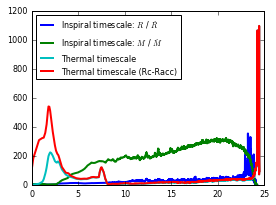

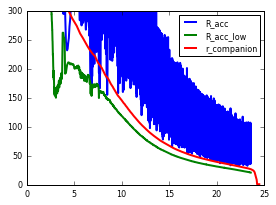

In [71]:
companion_position_m_at_profiles = np.interp(a.profile_age, a.history['star_age'],a.history["CE_companion_position_m"])
companion_position_r_at_profiles = np.interp(a.profile_age, a.history['star_age'],a.history["CE_companion_position_r"])
companion_position_r_at_profiles[np.where(companion_position_r_at_profiles<0.1)]=1
r_acc_low_at_profiles = np.interp(a.profile_age, a.history['star_age'],a.history["R_acc_low"])/Rsun
r_acc_low_at_profiles[np.where(r_acc_low_at_profiles<0.1)]=0

print(r_acc_low_at_profiles)

csound_at_companion = np.zeros(len(a.profile_age))
thermal_time_to_surface_at_companion = np.zeros(len(a.profile_age))
thermal_time_to_surface_at_companion_minus_R_acc = np.zeros(len(a.profile_age))

logRho_at_companion = np.zeros(len(a.profile_age))

# print(a.profiles[0].dtype.names)
# print(a.history.dtype.names)


for i in range(len(a.profile_age)):
    thermal_interp = interp1d(10.**a.profiles[i]["logR"],10.**a.profiles[i]["log_thermal_time_to_surface"]/secyear)
    thermal_time_to_surface_at_companion[i] = thermal_interp(companion_position_r_at_profiles[i])
    thermal_time_to_surface_at_companion_minus_R_acc[i] = thermal_interp(companion_position_r_at_profiles[i]-r_acc_low_at_profiles[i])
    csound_interp = interp1d(10**a.profiles[i]["logR"],a.profiles[i]["csound"])
    csound_at_companion[i] = csound_interp(companion_position_r_at_profiles[i])
    logRho_interp = interp1d(10**a.profiles[i]["logR"],a.profiles[i]["entropy"])
    logRho_at_companion[i] = logRho_interp(companion_position_r_at_profiles[i])
    



plt.figure(figsize=(4,3))

d_CE_companion_position_m_dt = -np.gradient(a.history["CE_companion_position_m"])/(10.**a.history["log_dt"])
d_CE_companion_position_r_dt = -np.gradient(a.history["CE_companion_position_r"])/(10.**a.history["log_dt"])

plt.plot(a.history["star_age"],savitzky_golay(a.history["CE_companion_position_r"]/d_CE_companion_position_r_dt,101,1),color="b",linewidth=2, label=r'Inspiral timescale: $R$ / $\dot{R}$')

plt.plot(a.history["star_age"],savitzky_golay(a.history["CE_companion_position_m"]/d_CE_companion_position_m_dt,101,1),color="g",linewidth=2, label=r'Inspiral timescale: $M$ / $\dot{M}$')
plt.plot(a.profile_age, thermal_time_to_surface_at_companion, color='c', label=r'Thermal timescale')

plt.plot(a.profile_age, thermal_time_to_surface_at_companion_minus_R_acc, color='r', label=r'Thermal timescale (Rc-Racc)')




plt.legend(loc=0,fontsize=8)

plt.tight_layout()


plt.savefig("timascales_30M_1400R_extrapolation.pdf")
plt.show()




plt.figure(figsize=(4,3))

d_logRho_d_CE_companion_position_m = -np.gradient(logRho_at_companion)/(companion_position_m_at_profiles)
d2_logRho_d_CE_companion_position_m2 = -np.gradient(d_logRho_d_CE_companion_position_m)/(companion_position_m_at_profiles)
d_logRho_d_CE_companion_position_r = -np.gradient(logRho_at_companion)/(companion_position_r_at_profiles)



# plt.plot(a.profile_age,savitzky_golay(d2_logRho_d_CE_companion_position_m2,1001,1),color="b",linewidth=2, label=r'log(density)')
plt.plot(a.history["star_age"][:-5000],a.history["R_acc"][:-5000]/Rsun, label="R_acc")
plt.plot(a.history["star_age"][:-5000],a.history["R_acc_low"][:-5000]/Rsun, label="R_acc_low")
plt.plot(a.profile_age,companion_position_r_at_profiles, label="r_companion")



# plt.plot(a.history["star_age"][:-5000],savitzky_golay(a.history["v_rel"][:-5000],101,1), label="v_rel")
# plt.plot(a.profile_age,savitzky_golay(csound_at_companion,11,1), label="Csound")

# plt.plot(a.history["star_age"][:-5000],savitzky_golay(a.history["v_over_c_sound"][:-5000],101,1), label="mach")



plt.legend(loc=0,fontsize=8)

plt.ylim([0,300])

plt.tight_layout()



plt.show()




### Now, let's look at some energies

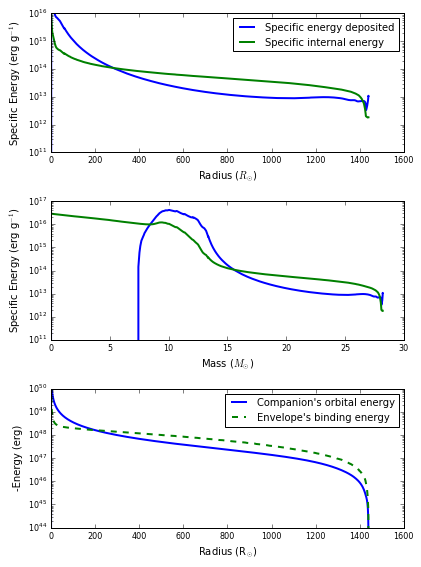

In [91]:
fig, ax = plt.subplots(3, 1, figsize=(6,8))


dE_dm = get_dE_dm(star['radius']*Rsun, M_companion, star_m_encl, star_dM_dr)

ax[0].plot(star['radius'], dE_dm, label='Specific energy deposited')
ax[0].plot(star['radius'], star['energy'], label='Specific internal energy')
ax[0].legend()
ax[0].set_ylim(1.0e11, 1.0e16)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'Radius ($R_{\odot}$)')
ax[0].set_ylabel(r'Specific Energy (erg g$^{-1}$)')
ax[0].axvline(merger_radius, color='k', linestyle='dashed')


ax[1].plot(star['mass'], dE_dm, label='Specific energy deposited')
ax[1].plot(star['mass'], star['energy'], label='Specific internal energy')
ax[1].set_ylim(1.0e11, 1.0e17)
ax[1].set_yscale('log')
ax[1].set_xlabel(r'Mass ($M_{\odot}$)')
ax[1].set_ylabel(r'Specific Energy (erg g$^{-1}$)')
ax[1].axvline(merger_mass, color='k', linestyle='dashed')


# Orbital energy
E_orb = -get_E_grav(star["mass"], M_companion, star["radius"])
ax[2].plot(star['radius'], E_orb - E_orb[0], linestyle='solid',  label="Companion's orbital energy")

# Gravitational binding energy
E_binding = np.zeros(len(star))
for j in np.arange(len(star)-1)+1:
    delta_E_binding = - get_E_grav(star["mass"][j], star['dm'][j]/Msun, star["radius"][j])
    E_binding[j] = E_binding[j-1] + delta_E_binding
ax[2].plot(star['radius'], E_binding, linestyle='dashed', label="Envelope's binding energy")
ax[2].legend(loc=0)


ax[2].set_xlabel(r'Radius (R$_{\odot}$)')
ax[2].set_ylabel('-Energy (erg)')

ax[2].set_yscale('log')
ax[2].set_ylim(1.0e44, 1.0e50)




plt.savefig("energetics_30M_1400R.png",dpi=300)
plt.tight_layout()
plt.show()

## Now calculate the Inspiral assuming a static model

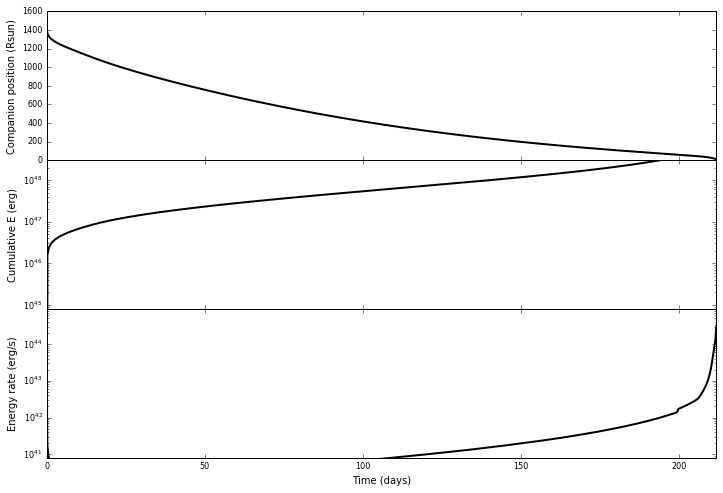

In [103]:
fig, ax = plt.subplots(3, figsize=(12,8), sharex=True)

tmin, tmax = 0.0, 1.83e7
# Radius evolution
r0 = (star["radius"][0]-1.)*Rsun
t = []
t = np.linspace(tmin, tmax, 1000)
#t = np.linspace(0.0, 1.0e5, 100)
r_sol = odeint(get_dr_dt, r0, t, args=(M_companion,star_m_encl, star_log10_rho, \
                                       star_pressure_scale_height, star_dM_dr,))
ax[0].plot(t/secday, r_sol/Rsun, color='k')
ax[0].set_ylabel('Companion position (Rsun)')

# Energy
# use the results of the previous integration to get "r_sol" corresponding to x-axis "t"
E0 = 0.0
E_sol = odeint(get_dE_dr, E0, r_sol.T[0], args=(M_companion,star_m_encl, star_log10_rho,))
ax[1].plot(t/secday, -E_sol, color='k')
ax[1].set_yscale('log')
ax[1].set_xlim(tmin/secday, tmax/secday)
ax[1].set_ylim(8e44,3.0e48)
ax[1].set_ylabel('Cumulative E (erg)')


# Energy Dissipation
ax[2].plot(t/secday, -get_dE_dt(0.0, r_sol.T[0], M_companion, star_m_encl, star_log10_rho, \
                                star_pressure_scale_height), color='k')
ax[2].set_ylabel('Energy rate (erg/s)')
ax[2].set_yscale('log')
ax[2].set_ylim(8e40, 9e44)

ax[2].set_xlabel('Time (days)')

fig.subplots_adjust(hspace=0)

plt.savefig('static_inspiral_integration_BH.png',dpi=300)

np.save("int_time_BH.npy",t/secday/365)
np.save("int_r_BH.npy",r_sol/Rsun)
np.save("int_m_BH.npy",star_m_encl(r_sol)/Msun)


In [101]:
star_m_encl(r_sol)/Msun

array([[ 28.20212169],
       [ 27.56073894],
       [ 27.38669501],
       [ 27.27415302],
       [ 27.19152747],
       [ 27.12421031],
       [ 27.06584577],
       [ 27.01291617],
       [ 26.96453798],
       [ 26.92069947],
       [ 26.88000888],
       [ 26.84139858],
       [ 26.80422962],
       [ 26.7682993 ],
       [ 26.73375077],
       [ 26.70064197],
       [ 26.66859421],
       [ 26.63743072],
       [ 26.60714947],
       [ 26.57752603],
       [ 26.54855496],
       [ 26.52007664],
       [ 26.49200949],
       [ 26.46440965],
       [ 26.43700289],
       [ 26.40987896],
       [ 26.38306513],
       [ 26.35634629],
       [ 26.33001099],
       [ 26.30378042],
       [ 26.27766243],
       [ 26.25172683],
       [ 26.22597088],
       [ 26.20005433],
       [ 26.17427748],
       [ 26.14867975],
       [ 26.12296032],
       [ 26.09719534],
       [ 26.07151171],
       [ 26.04590949],
       [ 26.02025626],
       [ 25.99444405],
       [ 25.96869105],
       [ 25